<a href="https://colab.research.google.com/github/dha5sm/project_voting/blob/main/Write_up_project_voiting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
!git clone https://github.com/dha5sm/project_voting/

import pandas as pd
import numpy as np
import os
from functools import reduce
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

fatal: destination path 'project_voting' already exists and is not an empty directory.


# **Summary**

In our analysis of the 2024 Virginia election using a KNN model, we focused on predicting county-level outcomes based on demographic factors like median household income and the proportion of people with bachelor's degrees. After normalizing our features and selecting an optimal k-value of 2, we achieved a predictive accuracy of approximately 74%. This model, however, was trained on 2020 election data and may not fully reflect the dynamics of the upcoming 2024 election, especially given increasing political polarization and reduced candidate-switching tendencies among voters. Despite these limitations, our KNN model demonstrated promising predictive capabilities, with around 75% accuracy in identifying Republican counties and 71% accuracy in identifying Democrat-majority counties. Nonetheless, further improvements are needed, as mispredictions in even a few counties could significantly impact state-level outcomes.

# **Data**

To prepare the data for analysis we first scanned over the csv files contained within the “county_data” folder. We filtered out the demographic estimates within this folder to include only those from the years 2016 - 2020. After reading the data from the csv files into dataframes, we isolated rows that were from the state of Virginia. Subsequently, we then worked to combine the separate dataframes into one main dataframe joint on the ‘GISJOIN’ field. This data table subsequently included all the demographic data for each county over the time period. The result was one demographics dataframe that contained data on every county in Virginia.


In [131]:
#Getting the name of all csv files to use
direct = './project_voting/data/county_data'
files = []
for file in os.listdir(direct):
  if file.endswith("E.csv"):
    files.append(file)

#Reading csv files to dataframe
dataframes = []
for file in files:
  if file == "0002_ds250_20205_county_E.csv" or file == "0002_ds249_20205_county_E.csv":
    df_cur = pd.read_csv(direct + "/" + file, encoding='ISO-8859-1')

    #Selecting rows only from the state of Virginia
    df_for_va =  df_cur[df_cur['STATE'] == 'Virginia']

    dataframes.append(df_for_va)

<ipython-input-131-8d49749d9c1d>:12: DtypeWarning: Columns (3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,26

In [132]:
#Only using most recent data of VA demographics to keep managable from 2016 to 2020
columns_keep = dataframes[0].columns
columns_keep = columns_keep.drop('GISJOIN')

df2 = dataframes[1]

#Removing duplicate columns from one dataframe
for col in columns_keep:
    if col in df2:
        df2 = df2.drop(columns=col)

df_VA2020 = pd.merge(dataframes[0], df2, on='GISJOIN')

#df_VA2020 contains all the demographic information for Virginia on a county by county basis for the years 2016 - 2020
#There are some columns with NAN values but will filter based on which columns are used / looked at

With that table in hand, we then worked to create a table with all the voting data by county in Virginia for the most recent election. This involved taking the original voting table and filtering by the most recent election. Because the same democratic and republican candidate are up for election, we determined this to be the most relevant years. (IDK WHAT THIS MEANS)


Next, for each county in the table there were 4 rows that displayed vote count by 4 parties: Democrat, Republican, Green, and Other. We believed this data would be more usable if for every county in Virginia there was one single row, instead of four, that contained a column showcasing how many votes each party received. The pivot table operation was used to accomplish this task.


In [133]:
#Get Data and check NA count
df_Votes = pd.read_csv("./project_voting/data/voting_VA.csv")
df_Votes.shape
na_count = df_Votes.isna().sum()

df_Votes_2020 = df_Votes[df_Votes['year'] == 2020]

df_Votes_party = df_Votes_2020.pivot_table(index="county_name", columns="party", values="candidatevotes", fill_value=0).reset_index()
df_Votes_party.head(20)

df_Votes_party.shape

(133, 5)

Following this, we noticed that some counties had a decimal figure for how many people voted for a party (probably due to the fact the original data was an estimate of the population). As such, we decided to convert the counties from strings to float values, after which we truncated the values by casting them to the integer type. Because the vote counts are so, losing a fraction of a voter would have limited impact on any predictions. Lastly, the various vote counts were then summed to create a new total count column.


In [134]:
cols = ['DEMOCRAT','LIBERTARIAN', 'OTHER', 'REPUBLICAN' ]

def convert_str(val):
  float_n = float(val)
  int_n = int(float_n)
  return int_n

for col in cols:
  df_Votes_party[col] = df_Votes_party[col].apply(convert_str)

#https://saturncloud.io/blog/how-to-sum-values-of-a-row-of-a-pandas-dataframe-efficiently/#:~:text=The%20most%20efficient%20way%20to,the%20values%20in%20each%20row.
df_Votes_party['total_votes'] = df_Votes_party[ cols ].sum(axis = 1)

#Check the data appears as expected
df_Votes_party.head()

party,county_name,DEMOCRAT,LIBERTARIAN,OTHER,REPUBLICAN,total_votes
0,ACCOMACK,2526,62,8,3057,5653
1,ALBEMARLE,14155,338,124,6934,21551
2,ALEXANDRIA CITY,22080,340,238,4848,27506
3,ALLEGHANY,747,29,4,1953,2733
4,AMELIA,803,26,4,1796,2629


Next, we worked to filter all the demographic data, selecting key fields in each county related to: Race, median household income, education status, and the frequency with which different languages are spoken at home. In consultation with the codebook, the variable names were identified and cleaned to have new, more easily understandable names.



In [135]:
cols_to_eval = []
df_test = df_VA2020[:20]

#Keeping the relevant information
columns_keep = ['GISJOIN', 'YEAR', 'STATE', 'COUNTY', 'COUNTYA', 'AMPWE001', 'AMPWE002', 'AMPWE003', 'AMPWE004', 'AMPWE005', 'AMPWE006', 'AMPWE007', 'AMR8E001', 'AMRZE022', 'AMRZE001', 'AMZLE001', 'AMZLE002', 'AMZLE003']
df_select_data = df_VA2020[columns_keep]

#Renaming the variables for analysis
col_names = {
    'AMPWE001':'Total_Reporting_Race',
    'AMPWE002':'White',
    'AMPWE003':'African_American',
    'AMPWE004': 'Indian_or_Alaska',
    'AMPWE005': 'Asian',
    'AMPWE006' : 'Pacific_Islander',
    'AMPWE007' : 'Other',
    'AMR8E001': 'Median_House_Income',
    'AMRZE022': 'People_with_Bachelors',
    'AMRZE001': 'Total_pop_asked_education',
    'AMZLE001' : 'Total_reporting_lang_at_home',
    'AMZLE002': 'English_in_home',
    'AMZLE003': 'Spanish_in_home'
}

df_select_data.rename(columns= col_names , inplace=True)
df_select_data['Other_lang_at_home'] = df_select_data['Total_reporting_lang_at_home'] - df_select_data['English_in_home'] - df_select_data['Spanish_in_home']


<ipython-input-135-477b406f7d5d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select_data.rename(columns= col_names , inplace=True)
<ipython-input-135-477b406f7d5d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select_data['Other_lang_at_home'] = df_select_data['Total_reporting_lang_at_home'] - df_select_data['English_in_home'] - df_select_data['Spanish_in_home']


Finally, we max - min adjusted the variables to that we could run a knn model and get our predictions.

In [136]:
df_Votes_party['net_votes'] = df_Votes_party['DEMOCRAT'] - df_Votes_party['REPUBLICAN']
def max_min_normalization(column):
    """Apply max-min normalization to a Pandas Series."""
    return (column - column.min()) / (column.max() - column.min())

The final form of the data prior to the analysis is highlighted in the table below.

In [137]:
df_select_data['county_name'] = df_select_data['COUNTY'].str.upper().str.replace(' COUNTY', '', regex=False)

#Merging df_votes and df_select on the 'county_name' column
df_merged = pd.merge(df_Votes_party, df_select_data, on='county_name', how='inner')

# Displaying merged df
df_merged.head()

<ipython-input-137-a9ec6b6e9577>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select_data['county_name'] = df_select_data['COUNTY'].str.upper().str.replace(' COUNTY', '', regex=False)


,county_name,DEMOCRAT,LIBERTARIAN,OTHER,REPUBLICAN,total_votes,net_votes,GISJOIN,YEAR,STATE,...,Asian,Pacific_Islander,Other,Median_House_Income,People_with_Bachelors,Total_pop_asked_education,Total_reporting_lang_at_home,English_in_home,Spanish_in_home,Other_lang_at_home
0,ACCOMACK,2526,62,8,3057,5653,-531,G5100010,2016-2020,Virginia,...,244,0,154,46178.0,2697,23813,13641,12355,679,607
1,ALBEMARLE,14155,338,124,6934,21551,7221,G5100030,2016-2020,Virginia,...,5981,48,989,84643.0,22495,73818,42381,37126,2058,3197
2,ALEXANDRIA CITY,22080,340,238,4848,27506,17232,G5105100,2016-2020,Virginia,...,10588,91,8565,102227.0,37466,119957,71289,50347,7869,13073
3,ALLEGHANY,747,29,4,1953,2733,-1206,G5100050,2016-2020,Virginia,...,10,0,64,48513.0,943,11155,6529,6376,89,64
4,AMELIA,803,26,4,1796,2629,-993,G5100070,2016-2020,Virginia,...,1,0,0,63918.0,1046,9270,5034,4799,206,29


#**Results**

To predict the election within the state of virginia for 2024, we decided to go with a KNN model. Specifically using the variables like Median household income and people with bachelors we were able to predict the outcome more accurately.  

In [138]:
# Normalizing the variables to use in the KNN model
features_to_normalize = ['Median_House_Income', 'Total_Reporting_Race', 'People_with_Bachelors']
for feature in features_to_normalize:
    df_merged[feature] = max_min_normalization(df_merged[feature])

In [139]:
X = df_merged[features_to_normalize].values
y = df_merged['net_votes'].values

# Splitting the data
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
def evaluate_k_values(X, y, k_values):
    mse_scores = []
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, scoring='neg_mean_squared_error', cv=5)
        mse_scores.append(np.mean(np.abs(scores)))  # Converting scores to positive MSE values
    return mse_scores

With the KNN model, we had to find the optimal k-value to reduce the mean squared error in the model without overfitting it to the test data.

In [141]:
k_values = range(1, 31)

# Evaluating MSE for each k-value
mse_scores = evaluate_k_values(X_train_norm, y_train, k_values)

# Finding the optimal k with the lowest MSE
optimal_k = k_values[np.argmin(mse_scores)]
optimal_k, mse_scores

(2,
 [59202641.22164502,
  54184041.16417749,
  62860008.5948052,
  63412320.93457793,
  68400672.67960171,
  72880615.58252767,
  71255811.77657919,
  69977767.74191694,
  73224200.19723691,
  74022147.21366233,
  75529345.63860326,
  77195206.65926827,
  79291678.58433105,
  80016579.06311955,
  81466398.70196827,
  82957986.78797181,
  83730857.20088378,
  83757387.28866042,
  84830152.84600016,
  85604865.31973055,
  86654150.77252701,
  87536887.31503256,
  88504332.96080819,
  89055671.93304096,
  89698483.69637887,
  90112676.32630959,
  90387387.35187264,
  90165434.9802307,
  90425648.54297142,
  90166488.2209091])

With this we can run our KNN model. Using our training data, we found that we can predict whether a country will be democratic or republican with a 74% accuracy rate.


In [142]:
#labels 1 for democrat and 0 for republican
df_merged['actual_label'] = (df_merged['net_votes'] > 0).astype(int)

# verifying optimal k value
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X, y)

# Finding the predicted net votes for the test set
predicted_net_votes = knn.predict(X)

# Convert the predictions back into binary codes
predicted_labels = (predicted_net_votes > 0).astype(int)

actual_labels = (y > 0).astype(int)

# Count correct and incorrect predictions
correct_predictions = np.sum(predicted_labels == actual_labels)
incorrect_predictions = len(predicted_labels) - correct_predictions

correct_predictions, incorrect_predictions
print("Accuracy: ", (correct_predictions)/(correct_predictions + incorrect_predictions))

Accuracy:  0.8270676691729323


It must be noted here that the data used was from the 2020 elections. It does not completly represent what will occur in 2024. More generally we know that people's opinions are becoming more and more polarized by party and there is less switching occuring by candidate.

Further analyzing our results with a confusion matrix we can see the 15/20 of our actual voting republicans, were predicted as such. Furthermore, 5/7 of our actual democrats were predicted as such. This 75% and 71% accuracy further highlights the ability of the model to use people's demographics to correctly identify the overall county level vote.

However, there is still some areas for improvement as the 7 counties were predicted wrong out of just 27. This would be enough to sway an election or the overall vote of a state. Further highlights how we can't be fully reliant on the output of this model's predictions.

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        87
           1       0.77      0.72      0.74        46

    accuracy                           0.83       133
   macro avg       0.81      0.80      0.81       133
weighted avg       0.83      0.83      0.83       133



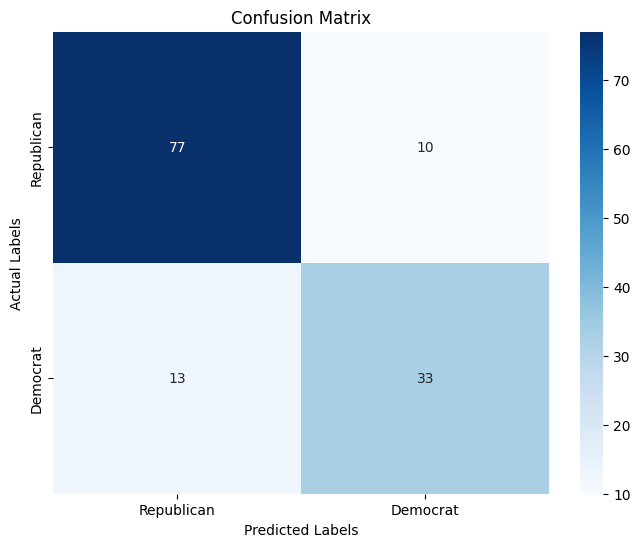

In [143]:
# Generate statistics
print("Classification Report:")
print(classification_report(actual_labels, predicted_labels))

# Show confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Republican', 'Democrat'], yticklabels=['Republican', 'Democrat'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

Below we can see the visual representation of the models predictions by county level. The dark blue counties represent the majority demographic counties, and the light blue counties represent the majority republican counties. Whilst only a few of the counties are demographic, combining this analysis with the map below by total number of votes, we can see that the democratic counties are all very heavily correlated with the counties with larger populations.

In [144]:
# Generate output dataframe
X_df = pd.DataFrame(X, columns=features_to_normalize)
results_df = pd.DataFrame({
    'County': df_merged['county_name'].iloc[X_df.index],  # County names from the merged dataframe
    'Actual_Net_Votes': y,
    'Predicted_Net_Votes': predicted_net_votes,
    'Predicted_Labels': predicted_labels,
    'Actual_Labels': actual_labels
})

results_df['Predicted_Labels'] = results_df['Predicted_Labels'].map({0: 'Republican', 1: 'Democrat'})

In [129]:
!pip3 install mapclassify

# Generate chloropleth maps
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load shapefile containing Virginia county boundaries
shapefile_path = "./project_voting/"
vdf = pd.read_csv('./project_voting/data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('./project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data
gdf = gpd.read_file(shapefile_path)

gdf_columns = gdf.columns.tolist()
print(gdf_columns)

gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')
df.head(10)



ERROR:fiona._env:Error in fread() reading object of size 13575360 at offset 100 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 53276 at offset 13575460 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 51516 at offset 13628736 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 63608 at offset 13680252 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 185768 at offset 13743860 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 53800 at offset 13929628 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 116984 at offset 13983428 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 77504 at offset 14100412 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 55608 at offset 14177916 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 100952 at offset 14233524 from .shp file
ERROR:fiona._env:Error in fre

['STCOFIPS', 'GNIS', 'NAME', 'NAMELSAD', 'GSOURCE', 'LADOPT', 'LASTUPDATE', 'JURISTYPE', 'AREASQMI', 'Shape_Leng', 'Shape_Area', 'geometry']


,STCOFIPS,GNIS,NAME,NAMELSAD,GSOURCE,LADOPT,LASTUPDATE,JURISTYPE,AREASQMI,Shape_Leng,...,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12
0,51001,1480091,Accomack,Accomack County,T,N,2014-08-20,CO,1195.366291,4.949957e+06,...,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51003,1675170,Albemarle,Albemarle County,L,Y,2021-03-29,CO,725.634334,2.310198e+05,...,Augusta,Rockingham,Greene,Orange,Louisa,Fluvanna,Buckingham,Nelson,NaN,NaN
2,51005,1492459,Alleghany,Alleghany County,V,N,2014-09-15,CO,449.544769,2.062654e+05,...,Botetourt,CovingtonCity,Rockbridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51007,1497770,Amelia,Amelia County,T,Y,2021-03-29,CO,360.945234,1.776617e+05,...,Powhatan,Chesterfield,Dinwiddie,Nottoway,NaN,NaN,NaN,NaN,NaN,NaN
4,51009,1480095,Amherst,Amherst County,V,N,2020-09-11,CO,478.766949,1.876610e+05,...,Appomattox,Campbell,Bedford,LynchburgCity,NaN,NaN,NaN,NaN,NaN,NaN
5,51011,1497238,Appomattox,Appomattox County,T,N,2020-09-11,CO,335.405489,1.362133e+05,...,Nelson,Buckingham,PrinceEdward,Charlotte,NaN,NaN,NaN,NaN,NaN,NaN
6,51013,1480097,Arlington,Arlington County,L,Y,2014-12-01,CO,26.064444,4.501493e+04,...,AlexandriaCity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,51015,1480098,Augusta,Augusta County,V,N,2014-08-01,CO,970.288077,3.069250e+05,...,Albemarle,Nelson,Rockbridge,Bath,StauntonCity,WaynesboroCity,NaN,NaN,NaN,NaN
8,51017,1673638,Bath,Bath County,L,Y,2014-08-01,CO,534.379403,1.806447e+05,...,Augusta,Rockbridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,51019,1674818,Bedford,Bedford County,L,Y,2021-09-23,CO,776.090456,2.691647e+05,...,Rockbridge,Amherst,LynchburgCity,Campbell,Pittsylvania,Franklin,BedfordCity,NaN,NaN,NaN


In [145]:
df['NAME'] = df['NAME'].str.upper()
joined_df = df.merge(results_df, left_on='NAME', right_on='County')
joined_df.drop(columns=['County_y'])
joined_df.head(10)

,STCOFIPS,GNIS,NAME,NAMELSAD,GSOURCE,LADOPT,LASTUPDATE,JURISTYPE,AREASQMI,Shape_Leng,...,N8,N9,N10,N11,N12,County_y,Actual_Net_Votes,Predicted_Net_Votes,Predicted_Labels,Actual_Labels
0,51001,1480091,ACCOMACK,Accomack County,T,N,2014-08-20,CO,1195.366291,4.949957e+06,...,NaN,NaN,NaN,NaN,NaN,ACCOMACK,-531,-1901.5,Republican,0
1,51003,1675170,ALBEMARLE,Albemarle County,L,Y,2021-03-29,CO,725.634334,2.310198e+05,...,Fluvanna,Buckingham,Nelson,NaN,NaN,ALBEMARLE,7221,442.0,Democrat,1
2,51005,1492459,ALLEGHANY,Alleghany County,V,N,2014-09-15,CO,449.544769,2.062654e+05,...,NaN,NaN,NaN,NaN,NaN,ALLEGHANY,-1206,-781.5,Republican,0
3,51007,1497770,AMELIA,Amelia County,T,Y,2021-03-29,CO,360.945234,1.776617e+05,...,NaN,NaN,NaN,NaN,NaN,AMELIA,-993,-930.0,Republican,0
4,51009,1480095,AMHERST,Amherst County,V,N,2020-09-11,CO,478.766949,1.876610e+05,...,NaN,NaN,NaN,NaN,NaN,AMHERST,-1790,-1682.0,Republican,0
5,51011,1497238,APPOMATTOX,Appomattox County,T,N,2020-09-11,CO,335.405489,1.362133e+05,...,NaN,NaN,NaN,NaN,NaN,APPOMATTOX,-1428,-912.0,Republican,0
6,51013,1480097,ARLINGTON,Arlington County,L,Y,2014-12-01,CO,26.064444,4.501493e+04,...,NaN,NaN,NaN,NaN,NaN,ARLINGTON,27675,14272.5,Democrat,1
7,51015,1480098,AUGUSTA,Augusta County,V,N,2014-08-01,CO,970.288077,3.069250e+05,...,WaynesboroCity,NaN,NaN,NaN,NaN,AUGUSTA,-6625,-6263.5,Republican,0
8,51017,1673638,BATH,Bath County,L,Y,2014-08-01,CO,534.379403,1.806447e+05,...,NaN,NaN,NaN,NaN,NaN,BATH,-396,-136.0,Republican,0
9,51019,1674818,BEDFORD,Bedford County,L,Y,2021-09-23,CO,776.090456,2.691647e+05,...,Franklin,BedfordCity,NaN,NaN,NaN,BEDFORD,-7808,-7216.5,Republican,0


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

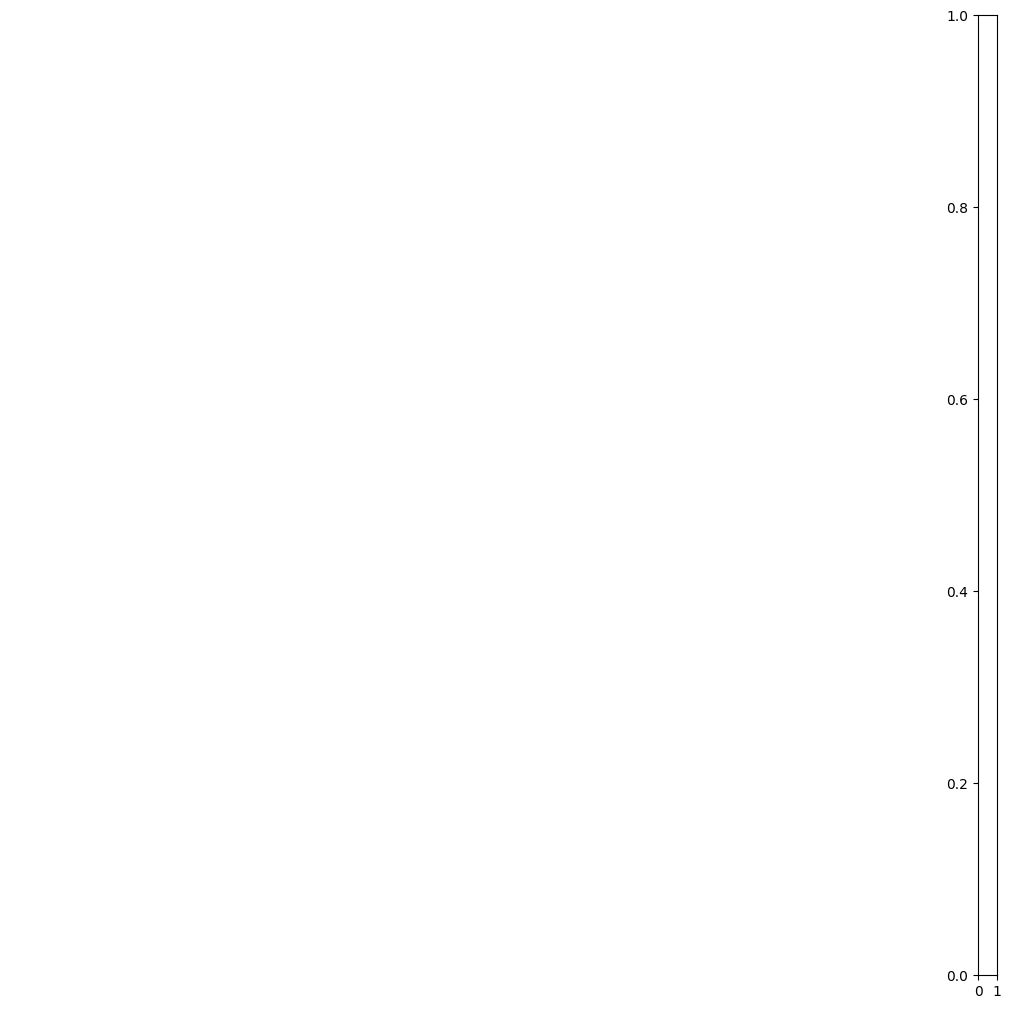

In [152]:
# Generate chloropleth map displaying counties that voted for democrat vs republican
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
joined_df.plot(ax=ax,column='Predicted_Labels',legend=True,cax=cax)

Furthermore, the boxplot below highlights how even though there was a majority of the Virginian counties were republican dominated, it does not accurately represent the population. There are significantly more democratic voters in the state of Virginia than republican. However, as seen in the map above, the majority of these voters like in three main counties (Fairfax, Albemarle, and Loudoun).

In [ ]:
# Generate output dataframe
X_test_norm_df = pd.DataFrame(X_test_norm, columns=features_to_normalize)
results_df = pd.DataFrame({
    'County': df_merged['county_name'].iloc[X_test_norm_df.index],  # County names from the merged dataframe
    'Actual_Net_Votes': y_test,
    'Predicted_Net_Votes': predicted_net_votes,
    'Predicted_Labels': predicted_labels,
    'Actual_Labels': actual_labels
})

# Group by predicted labels
results_df['Predicted_Labels'] = results_df['Predicted_Labels'].map({0: 'Republican', 1: 'Democrat'})

# Visualize predicted net votes by label
plt.figure(figsize=(10, 6))
sns.boxplot(x='Predicted_Labels', y='Predicted_Net_Votes', data=results_df)
plt.xlabel('Predicted Labels')
plt.ylabel('Predicted Net Votes')
plt.title('Predicted Net Votes by Label')
plt.show()

#**Conclusion**

In conclusion, our KNN model offered valuable insights into the potential voting patterns of Virginian counties for the upcoming 2024 election. With a predicted 15 republican counties, and 7 democratic counties we can model the overall consensus with a 74% accuracy. Additionally, we can also note that the county aggregate votes do not represent the votes by population as certain population dense counties in Virginia swing the states preferences as seen in the boxplot above. The model's accuracy, particularly in identifying county-level party majorities, underscores the significance of demographic variables in shaping political outcomes. However, the model's limitations, including its reliance on historical data and the complex nature of evolving voter preferences, highlight the need for caution in interpreting and relying solely on its predictions. Moving forward, incorporating more recent data and exploring additional predictive features could enhance the model's robustness and accuracy, enabling a more nuanced understanding of Virginia's political landscape in 2024. Ultimately, while our model provides a useful framework, it should be complemented with qualitative insights and continuous validation to ensure its reliability and relevance in predicting future election dynamics.